# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setting dataset and github

In [2]:
!mkdir -p ./dataset
!unzip /content/drive/MyDrive/server_security/colab/KISA/Malware/dataset/img256.zip -d ./dataset
!cp /content/drive/MyDrive/server_security/colab/KISA/Malware/dataset/malware1.csv ./dataset
!git clone https://github.com/Server-security-visualization/AI.git

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ./dataset/img256/a415947de7c148cbea0ad5ad3d933ffd.png  
  inflating: ./dataset/img256/a417e0673ee60dbd9ceaee8df251e6e2.png  
  inflating: ./dataset/img256/a4185e4d40e16361c5e46fa4fbc2f81c.png  
  inflating: ./dataset/img256/a419fa9ce4da3e5cd2b4d5a8c125d478.png  
  inflating: ./dataset/img256/a420fbe8235b8036ac8346b892253d98.png  
  inflating: ./dataset/img256/a43c7151a929e80993eb507240f24e2a.png  
  inflating: ./dataset/img256/a44005e45af542ef17d5ae66c19f8426.png  
  inflating: ./dataset/img256/a44512dcf380a2d88dc2f09ec4c4b1a3.png  
  inflating: ./dataset/img256/a446da6592f1ca3f0dc9fd62792463e1.png  
  inflating: ./dataset/img256/a450dc9e40d5107bf0cd4093f8ed8b97.png  
  inflating: ./dataset/img256/a4555781575b8a752704238c29f9a86e.png  
  inflating: ./dataset/img256/a455e718b226c610c35670e860309a20.png  
  inflating: ./dataset/img256/a45652571455ce98c5f0b928751f8cbe.png  
  inflating: ./dataset/img256/a461f293322fd236d0010ffd21f0bfda.png 

# import

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

# Load && Hyper Parameter

In [4]:
img_path = "./dataset/img256"
image_w = 256
image_h = 256
input_shape = (image_w, image_h, 1)

In [5]:
malware_df =pd.read_csv("./dataset/malware1.csv")
malware_df.head()

,Unnamed: 0,vir,png,len,malware
0,0,0003c3dd20cd99cf4555ab7c9232ec9c.vir,0003c3dd20cd99cf4555ab7c9232ec9c.png,192902,1
1,1,000590557e79980e147c3ff6521ec5cc.vir,000590557e79980e147c3ff6521ec5cc.png,199684,1
2,2,0006c099239df9bcaab4c3cbc85e6ff8.vir,0006c099239df9bcaab4c3cbc85e6ff8.png,42340,0
3,3,000fbf210ae21ff7604c025e1763a149.vir,000fbf210ae21ff7604c025e1763a149.png,440988,1
4,4,00123e9b2a49b6750df39ad0e86508e2.vir,00123e9b2a49b6750df39ad0e86508e2.png,614478,0


# Create Train, Val Dataset

In [6]:
x = []
y = []

for idx, row in tqdm(malware_df.iterrows()):
    path = f"{img_path}/{row['png']}"
    malware_class = row['malware']
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.reshape(image_w,image_h,1)
    
    x.append(img/255.)
    y.append(malware_class)
    
x = np.array(x)
y = np.array(y)
    
train_img, val_img, train_label, val_label = train_test_split(x, 
                                                  y, 
                                                  stratify=y, 
                                                  test_size=0.1)

15000it [00:11, 1260.41it/s]


In [7]:
train_img.shape, val_img.shape, train_label.shape, val_label.shape

((13500, 256, 256, 1), (1500, 256, 256, 1), (13500,), (1500,))

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_label)).shuffle(buffer_size=100000).batch(128)
val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_label)).batch(128)

# Def Model

In [9]:
def VGG16():
    vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, weights=None, input_shape=input_shape)
    
    model = tf.keras.models.Sequential([
        vgg16,
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    return model

In [10]:
def ResNet50():
    resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights=None, input_shape=input_shape)
    
    model = tf.keras.models.Sequential([
        resnet50,
        tf.keras.layers.Dense(512,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.BinaryCrossentropy(), 
                  metrics=['accuracy'])
    return model

# Train

In [13]:
folder_name = "malware_resnet50"
if not os.path.exists(f"./model"):
    os.mkdir(f"./model")
    print("./model")
if not os.path.exists(f"./img"):
    os.mkdir(f"./img")
    print("./img")
if not os.path.exists(f"./model/{folder_name}"):
    os.mkdir(f"./model/{folder_name}")
    print(f"create ./model/{folder_name}")
if not os.path.exists(f"./img/{folder_name}"):
    os.mkdir(f"./img/{folder_name}")
    print(f"create ./img/{folder_name}")

./img
create ./model/malware_resnet50
create ./img/malware_resnet50


In [14]:
model = ResNet50()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23581440  
                                                                 
 dense (Dense)               (None, 8, 8, 512)         1049088   
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,633,089
Trainable params: 24,578,945
No

In [15]:
save_path = f"./model/{folder_name}/"
checkpoint_path = save_path+"/model_{epoch}.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)

In [16]:
history = model.fit(train_dataset, 
                    epochs=30, 
                    validation_data=val_dataset, 
                    callbacks=[cp_callback])

Epoch 1/30
106/106 [==============================] - 86s 317ms/step - loss: 0.5082 - accuracy: 0.7547 - val_loss: 0.6150 - val_accuracy: 0.7000
Epoch 2/30
106/106 [==============================] - 27s 256ms/step - loss: 0.3914 - accuracy: 0.8151 - val_loss: 0.5831 - val_accuracy: 0.6833
Epoch 3/30
106/106 [==============================] - 27s 256ms/step - loss: 0.3518 - accuracy: 0.8434 - val_loss: 1.5218 - val_accuracy: 0.7000
Epoch 4/30
106/106 [==============================] - 27s 256ms/step - loss: 0.3163 - accuracy: 0.8635 - val_loss: 1.8759 - val_accuracy: 0.7000
Epoch 5/30
106/106 [==============================] - 27s 256ms/step - loss: 0.2965 - accuracy: 0.8719 - val_loss: 0.8610 - val_accuracy: 0.6960
Epoch 6/30
106/106 [==============================] - 27s 256ms/step - loss: 0.2664 - accuracy: 0.8860 - val_loss: 0.9814 - val_accuracy: 0.5433
Epoch 7/30
106/106 [==============================] - 27s 258ms/step - loss: 0.2482 - accuracy: 0.8954 - val_loss: 0.4784 - val_ac

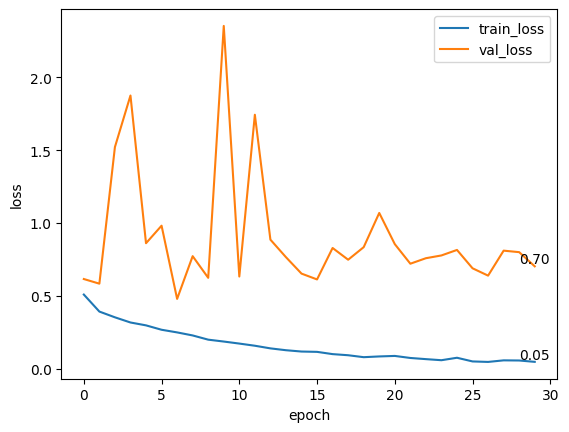

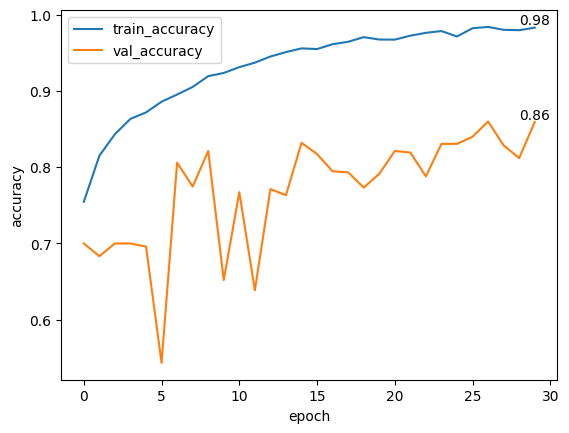

In [64]:
idx = 29
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.text(idx, history.history['loss'][idx], '%.2f' %  history.history['loss'][idx], ha='center', va='bottom', size = 10)
plt.text(idx, history.history['val_loss'][idx], '%.2f' %  history.history['val_loss'][idx], ha='center', va='bottom', size = 10)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.savefig(f"./img/{folder_name}/loss.png")
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.text(idx, history.history['accuracy'][idx], '%.2f' %  history.history['accuracy'][idx], ha='center', va='bottom', size = 10)
plt.text(idx, history.history['val_accuracy'][idx], '%.2f' %  history.history['val_accuracy'][idx], ha='center', va='bottom', size = 10)

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.savefig(f"./img/{folder_name}/acc.png")
plt.show()

# Save Goole Drive

In [18]:
!zip -r resnet50_model.zip ./model/malware_resnet50/* 

  adding: model/malware_resnet50/checkpoint (deflated 43%)
  adding: model/malware_resnet50/model_10.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_resnet50/model_10.ckpt.index (deflated 80%)
  adding: model/malware_resnet50/model_11.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_resnet50/model_11.ckpt.index (deflated 80%)
  adding: model/malware_resnet50/model_12.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_resnet50/model_12.ckpt.index (deflated 80%)
  adding: model/malware_resnet50/model_13.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_resnet50/model_13.ckpt.index (deflated 80%)
  adding: model/malware_resnet50/model_14.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_resnet50/model_14.ckpt.index (deflated 80%)
  adding: model/malware_resnet50/model_15.ckpt.data-00000-of-00001 (deflated 8%)
  adding: model/malware_resnet50/model_15.ckpt.index (deflated 80%)
  adding: model/malware_resnet50/model_16.ckpt.

In [65]:
!mv ./resnet50_model.zip /content/drive/MyDrive/server_security/colab/KISA/Malware/model
!mv ./img/malware_resnet50/* /content/drive/MyDrive/server_security/colab/KISA/Malware/img